<a href="https://colab.research.google.com/github/JMGilbert/STAT4241-Final-Project/blob/main/5241NN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Don't forget to enable GPU:    
Edit > Notebook settings or Runtime>Change runtime type    
and select GPU as Hardware accelerator.

In [ ]:
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from tqdm import tqdm as tq
from sklearn.metrics import cohen_kappa_score



train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


# Import Data

In [ ]:
#url of the dataset from our GitHub repository
url_red="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-red.csv"
url_white="https://raw.githubusercontent.com/JMGilbert/STAT4241-Final-Project/main/winequality-white.csv"
red=pd.read_csv(url_red,sep=';')
white=pd.read_csv(url_white,sep=';')

<BarContainer object of 7 artists>

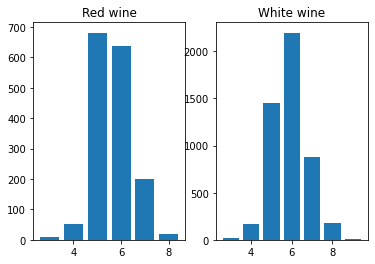

In [ ]:
plt.subplot(1,2,1).set_title("Red wine")
plt.bar(list(set(red["quality"])),red["quality"].value_counts(sort=False).sort_index())
plt.subplot(1,2,2).set_title("White wine")
plt.bar(list(set(white["quality"])),white["quality"].value_counts(sort=False).sort_index())

In [ ]:
print(white.isnull().values.any())
print(red.isnull().values.any())

False
False


In [ ]:
X_white=white.loc[:, white.columns != 'quality']
Y_white=white.loc[:, white.columns == 'quality']
X_red=red.loc[:, red.columns != 'quality']
Y_red=red.loc[:, red.columns == 'quality']

In [ ]:
def TO_TORCH(m):
    #convert an array/DF into a tensor with gpu on if necessary
    if isinstance(m, np.ndarray):
        m=torch.from_numpy(m).float()
    elif isinstance(m, pd.DataFrame):
        m=torch.from_numpy(m.values).float()
    if train_on_gpu:
        m = m.to(device="cuda")
    return(m)

# $\frac{2}{3}$/$\frac{1}{3}$ Holdout Split and Standardization

In [ ]:
X_TRAIN_white, X_TEST_white, Y_TRAIN_white, Y_TEST_white = train_test_split(X_white, Y_white, test_size=0.33, random_state=42)
X_TRAIN_red, X_TEST_red, Y_TRAIN_red, Y_TEST_red = train_test_split(X_red, Y_red, test_size=0.33, random_state=42)
TRAIN_scaler_white = preprocessing.StandardScaler().fit(X_TRAIN_white)
TEST_scaler_white = preprocessing.StandardScaler().fit(X_TEST_white)
X_TRAIN_white = TO_TORCH(TRAIN_scaler_white.transform(X_TRAIN_white))
X_TEST_white = TO_TORCH(TEST_scaler_white.transform(X_TEST_white))
TRAIN_scaler_red = preprocessing.StandardScaler().fit(X_TRAIN_red)
TEST_scaler_red = preprocessing.StandardScaler().fit(X_TEST_red)
X_TRAIN_red = TO_TORCH(TRAIN_scaler_red.transform(X_TRAIN_red))
X_TEST_red = TO_TORCH(TEST_scaler_red.transform(X_TEST_red))
Y_TRAIN_white = TO_TORCH(Y_TRAIN_white)
Y_TEST_white = TO_TORCH(Y_TEST_white)
Y_TRAIN_red = TO_TORCH(Y_TRAIN_red)
Y_TEST_red = TO_TORCH(Y_TEST_red)

# Nerual Networks

## Architecture

In [ ]:
# Neural Network structure
class Net(nn.Module):
    def __init__(self,INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM,DROP_PR=0.0,BN=False):
        super(Net, self).__init__()
        self.input_dim = INPUT_DIM
        self.output_dim = OUTPUT_DIM
        self.hidden_dim = HIDDEN_DIM
        self.DROP_PR = DROP_PR
        current_dim = self.input_dim
        self.layers = nn.ModuleList()
        self.BN=BN
        self.bn = nn.ModuleList()
        for hdim in self.hidden_dim:
            self.layers.append(nn.Linear(current_dim, hdim))
            self.bn.append(nn.BatchNorm1d(hdim))
            current_dim = hdim
        self.layers.append(nn.Linear(current_dim, self.output_dim))
        self.dropout = nn.Dropout(self.DROP_PR)

    def forward(self, x):
        for i, layer in enumerate(self.layers[:-1]):
            x = layer(x)
            if self.BN:
                x = self.bn[i](x)
            x = torch.sigmoid(x)
            x = self.dropout(x)
        out = self.layers[-1](x)
        return out 

#Loss function: mean absolute deviation
criterion = torch.nn.L1Loss() 

#Accuracy with tolerance
def ACCURACY(Y_pred,target,Tolerance):
    v=(abs(Y_pred-target)<=Tolerance)*1.0
    return(torch.mean(v))

#Kappa statistic compared with a random classifier
def KAPPA(Y_pred,target):
    #only work for Tolerance=0.5
    KAPP=cohen_kappa_score(target.cpu().detach().numpy(),torch.round(Y_pred).cpu().detach().numpy())
    #KAPP2=cohen_kappa_score(torch.round(Y_pred).cpu().detach().numpy(),target.cpu().detach().numpy())    
    return(KAPP)

## Toy example (Ignore this part)
red wine

In [ ]:
T=1 #Tolerance:0.25,0.5,1.0

LR=1e-2
OPT="SGD" # "SGD" or "ADAM"
EPOCH=30000

HIDDEN_DIM = [11]
INPUT_DIM = X_TRAIN_white.shape[1]
OUTPUT_DIM = 1
TOY_MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
if train_on_gpu:
    TOY_MODEL.cuda()
#Optimizer: 
if OPT=="SGD":
    optimizer = torch.optim.SGD(TOY_MODEL.parameters(),lr=LR)
if OPT=="ADAM":
    optimizer = torch.optim.Adam(TOY_MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=DECAY)

In [ ]:
LOSS_ARR=[]
torch.manual_seed(0)
for epoch in tq(range(EPOCH)):
    optimizer.zero_grad()
    outputs=TOY_MODEL(X_TRAIN_red) #prediction
    loss = criterion(outputs, Y_TRAIN_red) #compared with the true labels
    LOSS_ARR.append(loss.data)
    loss.backward()
    optimizer.step()    
    if (epoch+1)%round(EPOCH/5)==0:
        kappa=KAPPA(outputs, Y_TRAIN_red)
        accuracy=ACCURACY(outputs,Y_TRAIN_red,T).item()
        print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))


In [ ]:
zoom=np.floor(len(LOSS_ARR)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_ARR)-zoom)+zoom, LOSS_ARR[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_ARR[-1]))

In [ ]:
test_pred=TOY_MODEL(X_TEST_red)
loss = criterion(test_pred, Y_TEST_red)
print("Test MAD is {};".format(round(loss.item(),3)))
for T in [0.25,0.5,1.0]: 
    accuracy=ACCURACY(test_pred,Y_TEST_red,T).item()
    print("Test Accuracy is {}% (T={});".format(round(accuracy*100,3),T))
test_kappa=KAPPA(test_pred, Y_TEST_red)
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

## Wrap it up

In [ ]:
def TRAIN_NN(TRAIN_X,TRAIN_Y,HIDDEN_DIM,EPOCH,DROP_PR=0.0,BN=False,LR=1e-2,OPT="SGD",T=0.5):
    #TRAIN_X,TRIAN_Y: should be tensors
    # HIDDEN_DIM: [H] or deeper
    # BN: Bool, if using Batch Normalization or not
    # "SGD" or "ADAM"
    # T:0.25,0.5,1.0
    INPUT_DIM = TRAIN_X.shape[1]
    OUTPUT_DIM = 1
    MODEL=Net(INPUT_DIM,OUTPUT_DIM,HIDDEN_DIM)
    if train_on_gpu:
        MODEL.cuda()
    #Optimizer: 
    if OPT=="SGD":
        optimizer = torch.optim.SGD(MODEL.parameters(),lr=LR)
    if OPT=="ADAM":
        optimizer = torch.optim.Adam(MODEL.parameters(),lr=LR, betas=(0.9, 0.99))
    LOSS_ARR=[]
    torch.manual_seed(0)
    for epoch in tq(range(EPOCH)):
        optimizer.zero_grad()
        outputs=MODEL(TRAIN_X) #prediction
        loss = criterion(outputs, TRAIN_Y) #compared with the true labels
        LOSS_ARR.append(loss.data)
        loss.backward()
        optimizer.step()    
        if (epoch+1)%round(EPOCH/5)==0:
            kappa=KAPPA(outputs, TRAIN_Y)
            accuracy=ACCURACY(outputs,TRAIN_Y,T).item()
            print("\n After {} Epochs: MAD is {}; Accuracy is {}% (T={}); KAPPA is {}% (T=0.5)".format((epoch+1),round(loss.item(),3),round(accuracy*100,3),T,round(kappa*100,3)))
    return({"MODEL":MODEL,"LOSS_ARR":LOSS_ARR})

In [ ]:
def TEST_NN(MODEL,TEST_X,TEST_Y,T_list=[0.25,0.5,1]):
    MODEL.eval()
    test_pred=MODEL(TEST_X)
    loss = criterion(test_pred, TEST_Y)
    MAD=loss.item()
    accuracy_list=[ACCURACY(test_pred,TEST_Y,T).item() for T in T_list]
    kappa=KAPPA(test_pred, TEST_Y)
    MODEL.train()
    return({"MAD":MAD,"accuracy_list":accuracy_list,"kappa":kappa})

### White wine

In [ ]:
result_white=TRAIN_NN(X_TRAIN_white,Y_TRAIN_white,[11],EPOCH=30000)
MODEL_NN_white=result_white["MODEL"]
LOSS_white=result_white["LOSS_ARR"]

 21%|██        | 6218/30000 [00:05<00:19, 1238.59it/s]


 After 6000 Epochs: MAD is 0.578; Accuracy is 53.033% (T=0.5); KAPPA is 24.066% (T=0.5)


 40%|████      | 12125/30000 [00:09<00:14, 1200.32it/s]


 After 12000 Epochs: MAD is 0.574; Accuracy is 53.49% (T=0.5); KAPPA is 24.962% (T=0.5)


 61%|██████    | 18226/30000 [00:14<00:09, 1237.80it/s]


 After 18000 Epochs: MAD is 0.568; Accuracy is 53.49% (T=0.5); KAPPA is 25.102% (T=0.5)


 80%|████████  | 24138/30000 [00:19<00:04, 1225.67it/s]


 After 24000 Epochs: MAD is 0.56; Accuracy is 54.282% (T=0.5); KAPPA is 26.575% (T=0.5)


100%|██████████| 30000/30000 [00:24<00:00, 1238.25it/s]


 After 30000 Epochs: MAD is 0.554; Accuracy is 54.099% (T=0.5); KAPPA is 26.62% (T=0.5)


Text(0.5, 1.0, 'Final Loss = 0.5540362596511841')

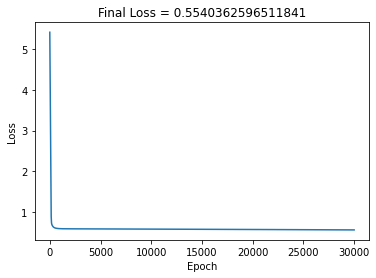

In [ ]:
zoom=np.floor(len(LOSS_white)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_white)-zoom)+zoom, LOSS_white[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_white[-1]))

In [ ]:
T_list=[0.25,0.5,1]
Result_TEST_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list)
print("Test MAD is {};".format(round(Result_TEST_white["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_white["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_white["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.569;
Test Accuracy is 28.262% (T=0.25);
Test Accuracy is 52.999% (T=0.5);
Test Accuracy is 84.106% (T=1);
Test KAPPA is 24.773% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

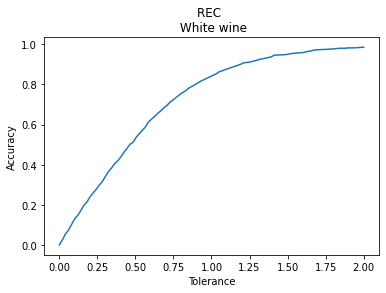

In [ ]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_white=TEST_NN(MODEL_NN_white,X_TEST_white,Y_TEST_white,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_white)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

### Red wine

In [ ]:
result_red=TRAIN_NN(X_TRAIN_red,Y_TRAIN_red,[11],EPOCH=30000)
MODEL_NN_red=result_red["MODEL"]
LOSS_red=result_red["LOSS_ARR"]

 21%|██        | 6235/30000 [00:05<00:19, 1217.55it/s]


 After 6000 Epochs: MAD is 0.477; Accuracy is 60.878% (T=0.5); KAPPA is 34.755% (T=0.5)


 41%|████      | 12168/30000 [00:10<00:14, 1203.30it/s]


 After 12000 Epochs: MAD is 0.468; Accuracy is 61.625% (T=0.5); KAPPA is 35.881% (T=0.5)


 61%|██████    | 18254/30000 [00:15<00:09, 1238.01it/s]


 After 18000 Epochs: MAD is 0.46; Accuracy is 62.278% (T=0.5); KAPPA is 37.073% (T=0.5)


 81%|████████  | 24209/30000 [00:20<00:04, 1267.49it/s]


 After 24000 Epochs: MAD is 0.455; Accuracy is 62.932% (T=0.5); KAPPA is 38.462% (T=0.5)


100%|██████████| 30000/30000 [00:24<00:00, 1209.09it/s]


 After 30000 Epochs: MAD is 0.451; Accuracy is 63.119% (T=0.5); KAPPA is 38.728% (T=0.5)


In [ ]:
zoom=np.floor(len(LOSS_red)/5).astype(int)
zoom=0
plt.plot(np.arange(len(LOSS_red)-zoom)+zoom, LOSS_red[zoom:])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Final Loss = {}".format(LOSS_red[-1]))

In [ ]:
T_list=[0.25,0.5,1]
Result_TEST_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list)
print("Test MAD is {};".format(round(Result_TEST_red["MAD"],3)))
for i,T in enumerate(T_list): 
    acc=Result_TEST_red["accuracy_list"][i]
    print("Test Accuracy is {}% (T={});".format(round(acc*100,3),T))
test_kappa=Result_TEST_red["kappa"]
print("Test KAPPA is {}% (T=0.5);".format(round(test_kappa*100,3)))

Test MAD is 0.496;
Test Accuracy is 36.364% (T=0.25);
Test Accuracy is 57.386% (T=0.5);
Test Accuracy is 88.826% (T=1);
Test KAPPA is 30.16% (T=0.5);


Text(0.5, 1.0, 'REC \n White wine')

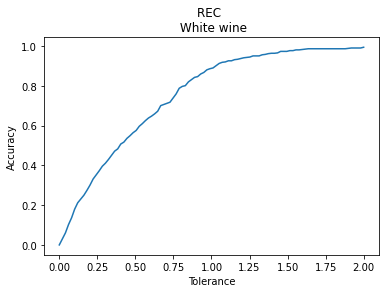

In [ ]:
T_list_REC=np.linspace(0,2,100)
ACCURACY_list_REC_red=TEST_NN(MODEL_NN_red,X_TEST_red,Y_TEST_red,T_list_REC)["accuracy_list"]
plt.plot(T_list_REC,ACCURACY_list_REC_red)
plt.xlabel("Tolerance")
plt.ylabel("Accuracy")
plt.title("REC \n White wine")

# Sensitivity Analysis (To be continued...

# 5-fold cross-validation